<a href="https://colab.research.google.com/github/RahilRehan/DeepLearningWithPytorch/blob/master/style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch 
import torch.optim as optim
from torchvision import datasets, transforms, models
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import drive
import numpy as np
%matplotlib inline

In [0]:
vgg = models.vgg19(pretrained=True).features

for param in vgg.parameters():
  param.requires_grad = False

In [0]:
device = "cuda" if torch.cuda.is_available() else "cpu"
vgg.to(device)
print(device)

cuda


In [0]:
drive.mount("/content/gdrive")
data_dir = "/content/gdrive/My Drive/Colab Notebooks/style_transfer"
!ls "/content/gdrive/My Drive/Colab Notebooks/style_transfer"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
content.jpeg  octopus.jpg  style1.jpeg	style3.jpeg
hockney.jpg   second.jpg   style2.jpeg


In [0]:
def load_image(img_path, max_size = 400):
  image = Image.open(data_dir+img_path).convert("RGB")
  if max(image.size) > max_size:
    size = max_size
  else:
    size = max(image.size)
  in_transforms = transforms.Compose([
                          transforms.Resize(size),
                          transforms.ToTensor(),
                          transforms.Normalize((0.485, 0.456, 0.406), 
                                  (0.229, 0.224, 0.225))
                                      ])
  image = in_transforms(image).unsqueeze(0)
  return image

In [0]:
def im_convert(tensor):
  image = tensor.to("cpu").clone().detach()
  image = image.numpy().squeeze()
  image = image.transpose(1,2,0)
  image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
  image = image.clip(0, 1)
  return image

In [0]:
content = load_image("/content.jpeg").to(device)
style = load_image("/style1.jpeg").to(device)

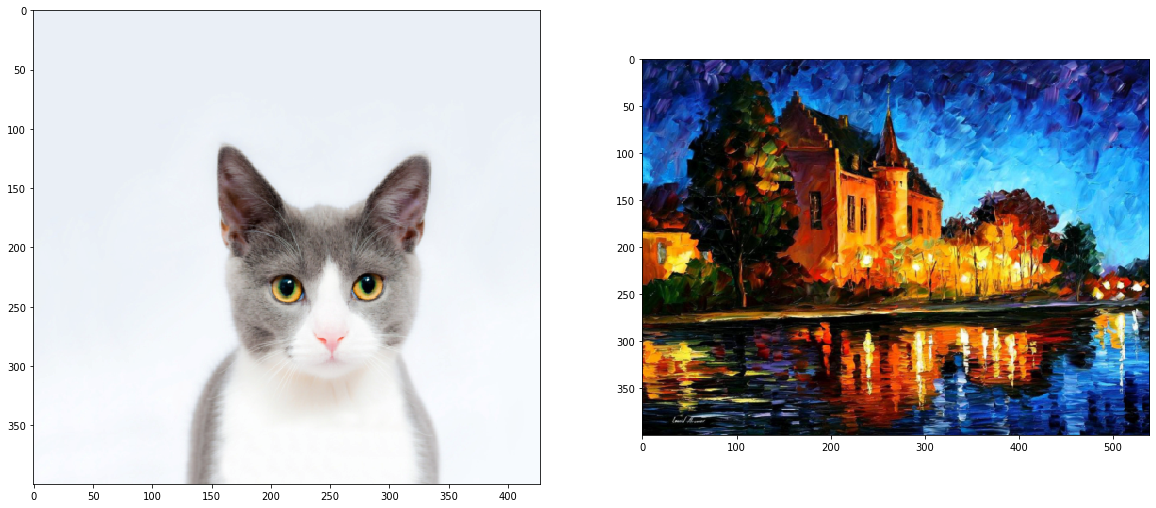

In [0]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

In [0]:
def get_features(image, model):
  layers = {
      '0': 'conv1_1',
      '5': 'conv2_1', 
      '10': 'conv3_1', 
      '19': 'conv4_1',
      '21': 'conv4_2',
      '28': 'conv5_1'
  }
  features = {}
  x = image
  for name,layer in model._modules.items():
    x = layer(x)
    if name in layers:
      features[layers[name]] = x
  return features
  # for f in features.keys():
  #   print(features[f].shape)


In [0]:
def gram_matrix(tensor):
  _, d, h, w = tensor.size()
  tensor = tensor.view(d, h*w)
  gram = torch.mm(tensor, tensor.T)
  return gram

In [0]:
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

style_grams = {layer:gram_matrix(style_features[layer]) for layer in style_features}

target = content.clone().requires_grad_(True).to(device)

In [0]:
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1  # alpha
style_weight = 1e6  # beta

Total loss:  416339296.0


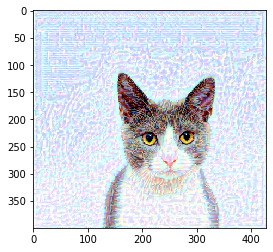

Total loss:  215040608.0


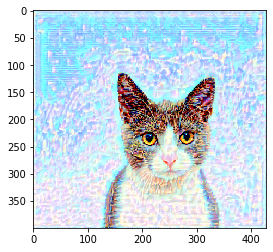

Total loss:  122963320.0


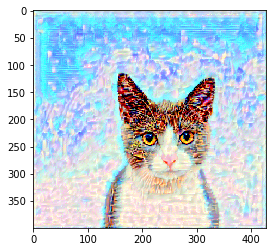

Total loss:  75383976.0


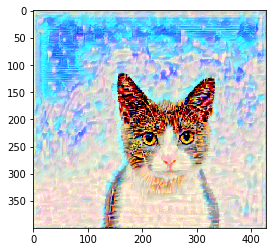

Total loss:  48369036.0


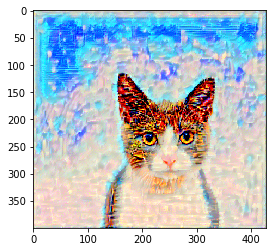

Total loss:  33450190.0


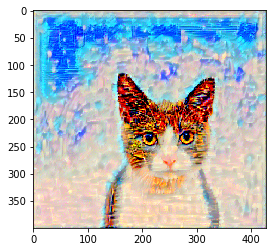

Total loss:  24962286.0


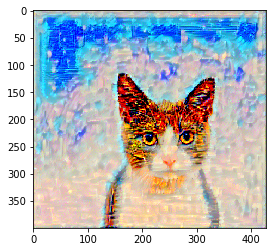

Total loss:  19692238.0


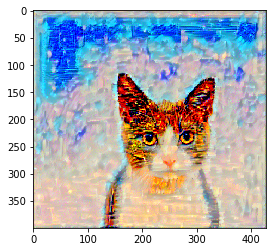

In [0]:
optimizer = optim.Adam([target], lr = 0.003)
steps = 3200
show_every = 400
for ii in range(1, steps+1):
  target_features = get_features(target, vgg)
  content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
  style_loss = 0
    # then add to it for each layer's gram matrix loss
  for layer in style_weights:
      # get the "target" style representation for the layer
      target_feature = target_features[layer]
      target_gram = gram_matrix(target_feature)
      _, d, h, w = target_feature.shape
      # get the "style" style representation
      style_gram = style_grams[layer]
      # the style loss for one layer, weighted appropriately
      layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
      # add to the style loss
      style_loss += layer_style_loss / (d * h * w)
      
  # calculate the *total* loss
  total_loss = content_weight * content_loss + style_weight * style_loss
  
  # update your target image
  optimizer.zero_grad()
  total_loss.backward()
  optimizer.step()
  
  # display intermediate images and print the loss
  if  ii % show_every == 0:
      print('Total loss: ', total_loss.item())
      plt.imshow(im_convert(target))
      plt.show()

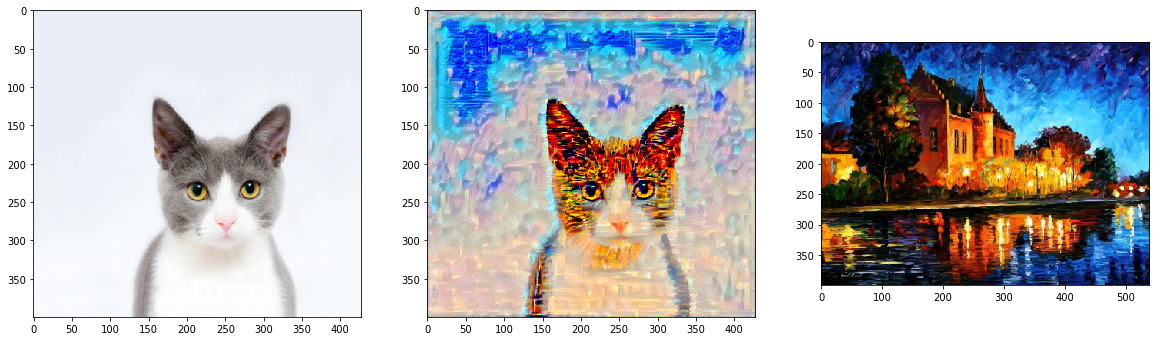

In [0]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(target))
ax3.imshow(im_convert(style))